In [1]:
import numpy as np
import pandas as pd
import json
import glob
from tqdm import tqdm

import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
from gensim.models import TfidfModel

import spacy
from nltk.corpus import stopwords

import pyLDAvis.gensim_models

import warnings
warnings.filterwarnings('ignore')

c:\users\krister\climdist\gensim_env\lib\site-packages\gensim\similarities\__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)


### Initialiser un modèle de sujet et trouver ses meilleurs paramètres d'entrée

Executer le script 'lda_optimizer.py' dans le dossier ./climdist/lda qui donnera un fichier .json comme sortie.

In [60]:
import codecs
import json

with codecs.open('../pipeline/04_lda/optimal_n_topics.json') as f:
    contents = f.read()
    scores_data = json.loads(contents)

In [61]:
df_scores = pd.DataFrame(scores_data)

def maxscore(row):
    scores = [score[1] for score in row]
    return max(scores)

def n_topics(row):
    scores = [score[1] for score in row]
    ix = scores.index(max(scores))
    return row[ix][0]
    
df_scores['best_score'] = df_scores.scores.apply(maxscore)
df_scores['optimal_n_topics'] = df_scores.scores.apply(n_topics)
df_scores = df_scores.sort_values(by='best_score', ascending=False)

df_scores

,alpha,treshold,scores,best_score,optimal_n_topics
15,auto,0.6,"[[3, 0.4005551803452463], [6, 0.41526470527247...",0.508817,9
19,auto,0.7,"[[3, 0.4005551803452463], [6, 0.41526470527247...",0.508817,9
17,0.2,0.7,"[[3, 0.4009381826150482], [6, 0.38765569733740...",0.497733,9
13,0.2,0.6,"[[3, 0.4009381826150482], [6, 0.38765569733740...",0.497733,9
3,auto,0.3,"[[3, 0.4880274585601036], [6, 0.44171889656315...",0.488027,3
12,0.1,0.6,"[[3, 0.39928331127075195], [6, 0.3991503369132...",0.487243,9
16,0.1,0.7,"[[3, 0.39928331127075195], [6, 0.3991503369132...",0.487243,9
7,auto,0.4,"[[3, 0.4306305104987627], [6, 0.48663718905437...",0.486637,6
5,0.2,0.4,"[[3, 0.43063051049876266], [6, 0.4844833285218...",0.484483,6
27,auto,0.9,"[[3, 0.3766170727011751], [6, 0.45220941894564...",0.482598,9


#### A partir des résultats ordonnés par leur score de cohérence, on va choisir les meilleurs et les comparer

In [24]:
df = pd.read_excel('../data/processed/LNB_processed.xlsx')
nlp = spacy.load('../data/models/spacy_model_250421')

In [31]:
lda.nlp = nlp

lda.stops = stopwords.words('german')
lda.common_ocr_errors = ['nnr', 'nnd', 'fich', 'find']
lda.other_noise = ['januar', 'februar', 'märz', 'april', 'mai', 'juni', 'juli', 'august', 'september', 'october', 'oktober', 'november', 'dezember', 'december']
lda.stops += lda.common_ocr_errors + lda.other_noise

In [174]:
from climdist.lda import lda

data = df[(df.w_count > 100) & (df.w_count < 3000)].sample(3000).full_text.values

lemmatized_data = lda.lemmatize(data, allowed_postags=['NOUN', 'ADJ', 'VERB'])
data_words = lda.gen_words(lemmatized_data)

bigram_phrases = gensim.models.Phrases(data_words, min_count=2)
trigram_phrases = gensim.models.Phrases(bigram_phrases[data_words], threshold=10)
bigram = gensim.models.phrases.Phraser(bigram_phrases)
trigram = gensim.models.phrases.Phraser(trigram_phrases)

data_bigrams = [bigram[doc] for doc in data_words]
data_bigrams_trigrams = [trigram[bigram[doc]] for doc in data_words]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3000/3000 [27:56<00:00,  1.79it/s]


In [175]:
id2word5 = corpora.Dictionary(data_bigrams_trigrams)
id2word5.filter_extremes(no_above=df_scores.treshold.iloc[0])
corpus5 = [id2word5.doc2bow(text) for text in data_bigrams_trigrams]
tfidf5 = TfidfModel(corpus5, id2word=id2word5)

lda_model_5 = gensim.models.ldamodel.LdaModel(corpus=corpus5,
                                   id2word=id2word5,
                                   num_topics=df_scores.optimal_n_topics.iloc[0],
                                   random_state=100,
                                   update_every=1,
                                   chunksize=100,
                                   passes=10,
                                   alpha=df_scores.alpha[0])

coherence_model = gensim.models.CoherenceModel(model=lda_model_5, texts=data_bigrams_trigrams, coherence='c_v')
coherence_score = coherence_model.get_coherence()
print('Coherence Score: ', coherence_score)

vis_5 = pyLDAvis.gensim_models.prepare(lda_model_5, corpus5, id2word5, mds='mmds', R=30)
vis_5

Coherence Score:  0.4318863794618333


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2     -0.328982 -0.011779       1        1  25.540346
3      0.028539  0.205687       2        1  17.279316
4     -0.138266  0.092009       3        1  15.193111
5     -0.222902 -0.203472       4        1  15.188277
0     -0.030534 -0.321444       5        1   9.961510
6     -0.242059  0.311230       6        1   8.607432
7      0.228528 -0.303738       7        1   3.612928
8      0.389474 -0.060291       8        1   3.341760
1      0.316203  0.291797       9        1   1.275320, topic_info=           Term         Freq        Total Category  logprob  loglift
166        jahr  4481.000000  4481.000000  Default  30.0000  30.0000
158        herr  3641.000000  3641.000000  Default  29.0000  29.0000
1077  regierung  2193.000000  2193.000000  Default  28.0000  28.0000
2584     wasser  1052.000000  1052.000000  Default  27.0000  27.0000
580       herrn  2119.000000  2119.000000  Default  26.0000  26.0000
...         ...          ...          ...      ...      ...      ...
3492      warme    51.943670   200.966240   Topic9  -5.5127   3.0090
1195      breit    50.307851   171.527212   Topic9  -5.5447   3.1354
1821       hohe    54.223345   504.869211   Topic9  -5.4698   2.1308
928    bewegung    51.225315   523.826748   Topic9  -5.5267   2.0370
1741       berg    47.970188   420.336651   Topic9  -5.5923   2.1915

[654 rows x 6 columns], token_table=       Topic      Freq          Term
term                                
1147       1  0.306201         abend
1147       2  0.007315         abend
1147       3  0.264399         abend
1147       5  0.311426         abend
1147       6  0.110776         abend
...      ...       ...           ...
360        7  0.216666           ztg
15741      7  0.991161       zunahme
8034       4  0.987750  zusammenhang
14495      7  0.986213     zustellen
12959      9  0.971369      zuziehen

[1361 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 4, 5, 6, 1, 7, 8, 9, 2])

In [176]:
def create_topic_df(model, corpus, original_texts):
    
    num_topics = len(model.get_topics())
    col_names = ['doc'] + list(range(1, num_topics+1))
    print(col_names)
    
    topic_df = pd.DataFrame(columns=col_names)
    topic_df['doc'] = original_texts
    
    print(topic_df.columns)
    
    for i in range(0, len(original_texts)):
        doc_topics = model[corpus[i]]
        for entry in doc_topics:
            topic_no = entry[0]+1
            topic_df.iloc[i, topic_no] = entry[1]

    return topic_df

In [177]:
topics = create_topic_df(lda_model_5, corpus5, data)
topics

['doc', 1, 2, 3, 4, 5, 6, 7, 8, 9]
Index(['doc', 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype='object')


,doc,1,2,3,4,5,6,7,8,9
0,Inland\n\nDie Hebung des russischen Wein-\nban...,0.086098,NaN,0.072989,0.158665,0.100936,0.377096,0.059156,0.102825,0.042019
1,Inhalt.\n\n£ie augenblickliche Geldkrisis in N...,NaN,NaN,0.061332,0.46351,0.429578,NaN,NaN,0.036113,NaN
2,"l.\n\nUeber die ""Emancipation"" der Frauen\n\ni...",NaN,NaN,0.426926,0.23429,0.015072,0.301889,NaN,NaN,NaN
3,Allerlei.\n\nlD e n früheren kleinstaa t l i e...,0.046021,NaN,0.184953,NaN,0.123376,0.47537,NaN,0.166183,NaN
4,"Krajowa, den 2. August.\nKrajowa, den 2. Augus...",NaN,NaN,NaN,0.051403,0.493936,NaN,0.435832,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
2995,Bekanntmachungen.\n\nA l)a * Dampfschiff „\<*u...,0.471179,NaN,0.067782,0.016812,0.172042,NaN,NaN,0.050368,0.220614
2996,Ausland.\n\nOesterreichisebe Dionen-spie. -\nW...,0.034549,NaN,0.114666,0.263301,0.29044,0.101782,0.16486,NaN,0.025393
2997,Ausland.\n\nÜom spanisch-amerikanischen\nKrieg...,0.035964,NaN,0.272537,0.274162,0.123079,0.150428,0.116649,0.01035,0.016723
2998,Ausland.\n\nWien 3. August. Nachrichten auS Ko...,0.022949,NaN,0.056384,0.326934,0.163099,0.047328,0.34708,NaN,0.03475


In [179]:
topics.sort_values(by=3, ascending=False)

,doc,1,2,3,4,5,6,7,8,9
2258,Am Meere.\n\nRomanze von Johannes Krajewski.\n...,NaN,NaN,0.986405,NaN,NaN,NaN,NaN,NaN,NaN
906,"Natnrerziehung.\n\nN. Asmuß.\n\nDer Frühling, ...",NaN,NaN,0.942369,NaN,0.046479,NaN,NaN,NaN,NaN
64,Am schwarzen Teiche.\n\nEin Bild auS dem chine...,NaN,0.020369,0.929321,0.018196,0.031163,NaN,NaN,NaN,NaN
278,Dämmerungen*).\nDämmerungen*).\n\nRoman in dre...,NaN,0.031538,0.926791,NaN,0.022694,NaN,NaN,NaN,NaN
2554,"Warnung.\n\nIst dem Baum se» Laub genommen,\nS...",NaN,NaN,0.922215,NaN,0.064281,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
2855,"Inland.\nInland.\n\nSt. Petersburg, 28. August...",0.155337,NaN,NaN,0.035071,0.325708,0.058842,0.419822,NaN,NaN
2859,"St. Petersburg, den 7. Januar.\n\nDer Oberst T...",0.108613,NaN,NaN,0.073327,0.581305,0.062086,0.038265,0.13351,NaN
2882,"Nichtofficielle Telegramme.\n\nB e rìi n, 30. ...",0.010551,NaN,NaN,0.107744,0.45356,0.027339,0.1569,0.234027,NaN
2919,Dampfschisffahrt\n\nBericht vom Dampssihiss Dü...,0.172827,NaN,NaN,NaN,0.805219,NaN,NaN,NaN,NaN


In [184]:
print(topics.sort_values(by=3, ascending=False)['doc'][2])

l.

Ueber die "Emancipation" der Frauen

ist vom kirchlichen, soeialen, sittlichen, öconomischetn rechtlichetn
medieinischen und sonsiigen Standpunkt schon so viel Verwor-
renes geschrieben, daß wir uns nur freuen, ein vernünftiges
Workhier mittheilen zu können» das wir» der Zeitschrift
»··Z,«ykm December-DER entnehmen. Bei) der Be:
« « eines Buches über diesen Gegenstand von dem be—-
rübtnten Proelatnator der neuen Aera des weiblichen Ge-
schlethts, lohn Stuart Mill, heißt» es folgendermaßen:
»Diese Blätter haben-mit warmem Interesse die Bestre-
bungen unserer Tage verfolgt, das Loos der Frauen zu ver-
bessern, Unbilligkeiten der Gesetze und der Sitte zu beseitigen,
unter denen sie noch leiden, und ihnen neue Berufswege zu
eröffnen. Es muß daher die Aufmerksamkeit derselben erregen,
wenn einer der ersten Nationalöconotnen und Philosophen der
Gegenwart das Wort in dieser Sache nimmt. Freilich können
wir dabei von vornherein das Bedenken nicht unterdrücken,
daß Mill schon in seinem epoc

In [129]:
topicslist = lda_model_5[corpus[100]]
print(topicslist)

total = 0
for entry in topicslist:
    total += entry[1]
print(total)

[(0, 0.37813342), (1, 0.12175408), (2, 0.033176772), (3, 0.04377312), (4, 0.033892773), (6, 0.11807524), (7, 0.056843847), (8, 0.21394669)]
0.9995959289371967


In [132]:
dftotal = 0
for i in [1,2,7,8]:
    dftotal += a.iloc[0,i]
dftotal
    

0.9905355721712112

In [90]:
### Model 1

id2word0 = corpora.Dictionary(data_bigrams_trigrams)
id2word0.filter_extremes(no_above=df_scores.treshold.iloc[0])
corpus0 = [id2word0.doc2bow(text) for text in data_bigrams_trigrams]
tfidf0 = TfidfModel(corpus0, id2word=id2word0)

print(f'Treshold {df_scores.treshold.iloc[0]}, alpha {df_scores.alpha.iloc[0]}')
    
lda_model_0 = gensim.models.ldamodel.LdaModel(corpus=corpus0,
                                   id2word=id2word0,
                                   num_topics=df_scores.optimal_n_topics.iloc[0]-1,
                                   random_state=100,
                                   update_every=1,
                                   chunksize=100,
                                   passes=10,
                                   alpha=df_scores.alpha[0])

vis_0 = pyLDAvis.gensim_models.prepare(lda_model_0, corpus0, id2word0, mds='mmds', R=30)
vis_0

Treshold 0.6, alpha auto


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
6     -0.078769  0.036141       1        1  28.762739
0      0.300696  0.155122       2        1  20.453780
3      0.275123 -0.096490       3        1  12.716225
1      0.091779  0.332542       4        1  11.770339
5     -0.123107 -0.268272       5        1  10.879156
2     -0.219841  0.328007       6        1   7.148345
4      0.165462 -0.391087       7        1   4.256761
7     -0.411342 -0.095963       8        1   4.012654, topic_info=         Term         Freq        Total Category  logprob  loglift
19       jahr  5552.000000  5552.000000  Default  30.0000  30.0000
138      mann  3283.000000  3283.000000  Default  29.0000  29.0000
256   general  1428.000000  1428.000000  Default  28.0000  28.0000
863     konig  1492.000000  1492.000000  Default  27.0000  27.0000
1287   truppe  1188.000000  1188.000000  Default  26.0000  26.0000
...       ...          ...          ...      ...      ...      ...
899        se    74.737027   158.331383   Topic8  -5.7040   2.4650
1657    krone    81.139372   304.845453   Topic8  -5.6218   1.8921
17      herrn   103.421125  1971.618192   Topic8  -5.3792   0.2679
189     stadt   109.150057  3097.553163   Topic8  -5.3253  -0.1299
2264      nen    79.659205   300.088324   Topic8  -5.6402   1.8894

[552 rows x 6 columns], token_table=      Topic      Freq        Term
term                             
585       1  0.064872       abend
585       2  0.345660       abend
585       3  0.291439       abend
585       4  0.133616       abend
585       6  0.121029       abend
...     ...       ...         ...
244       1  0.992724  zustimmung
1295      1  0.576847       zweck
1295      3  0.330353       zweck
1295      4  0.002541       zweck
1295      5  0.090212       zweck

[1068 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[7, 1, 4, 2, 6, 3, 5, 8])

In [91]:
id2word1 = corpora.Dictionary(data_bigrams_trigrams)
id2word1.filter_extremes(no_above=df_scores.treshold.iloc[1])
corpus1 = [id2word1.doc2bow(text) for text in data_bigrams_trigrams]
tfidf1 = TfidfModel(corpus1, id2word=id2word1)

print(f'Treshold {df_scores.treshold.iloc[1]}, alpha {df_scores.alpha.iloc[1]}')
    
lda_model_1 = gensim.models.ldamodel.LdaModel(corpus=corpus1,
                                   id2word=id2word1,
                                   num_topics=df_scores.optimal_n_topics.iloc[1],
                                   random_state=100,
                                   update_every=1,
                                   chunksize=100,
                                   passes=10,
                                   alpha=df_scores.alpha[1])

vis_1 = pyLDAvis.gensim_models.prepare(lda_model_1, corpus1, id2word1, mds='mmds', R=30)
vis_1

Treshold 0.7, alpha auto


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
3     -0.124755 -0.020183       1        1  23.418421
4      0.070640  0.151760       2        1  21.178489
6     -0.328938  0.130438       3        1  13.792117
5     -0.336375 -0.224095       4        1  11.392862
0     -0.022894 -0.302474       5        1   9.343506
1     -0.142031  0.319040       6        1   8.348161
7      0.221407 -0.308245       7        1   6.237650
8      0.359355 -0.065773       8        1   4.676507
2      0.303591  0.319533       9        1   1.612286, topic_info=         Term         Freq        Total Category  logprob  loglift
19       jahr  5622.000000  5622.000000  Default  30.0000  30.0000
110      herr  3831.000000  3831.000000  Default  29.0000  29.0000
1717     volk   992.000000   992.000000  Default  28.0000  28.0000
257   general  1431.000000  1431.000000  Default  27.0000  27.0000
139      mann  3260.000000  3260.000000  Default  26.0000  26.0000
...       ...          ...          ...      ...      ...      ...
304     feier    46.771327   219.665709   Topic9  -5.2739   2.5807
1822    macht    53.873648   758.190631   Topic9  -5.1326   1.4832
21       land    59.039812  2490.586610   Topic9  -5.0410   0.3855
336     kraft    50.934046   880.054350   Topic9  -5.1887   1.2781
1649   gefuhl    41.584239   396.169936   Topic9  -5.3915   1.8734

[639 rows x 6 columns], token_table=      Topic      Freq   Term
term                        
587       1  0.088254  abend
587       2  0.299082  abend
587       4  0.308888  abend
587       5  0.184352  abend
587       7  0.081389  abend
...     ...       ...    ...
1297      1  0.431179  zweck
1297      2  0.052148  zweck
1297      3  0.333242  zweck
1297      4  0.043245  zweck
1297      6  0.139911  zweck

[1237 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[4, 5, 7, 6, 1, 2, 8, 9, 3])

In [92]:
id2word2 = corpora.Dictionary(data_bigrams_trigrams)
id2word2.filter_extremes(no_above=df_scores.treshold.iloc[2])
corpus2 = [id2word2.doc2bow(text) for text in data_bigrams_trigrams]
tfidf2 = TfidfModel(corpus2, id2word=id2word2)

print(f'Treshold {df_scores.treshold.iloc[2]}, alpha {df_scores.alpha.iloc[2]}')

lda_model_2 = gensim.models.ldamodel.LdaModel(corpus=corpus2,
                                   id2word=id2word2,
                                   num_topics=df_scores.optimal_n_topics.iloc[2],
                                   random_state=100,
                                   update_every=1,
                                   chunksize=100,
                                   passes=10,
                                   alpha=df_scores.alpha[2])

vis_2 = pyLDAvis.gensim_models.prepare(lda_model_2, corpus2, id2word2, mds='mmds', R=30)
vis_2

Treshold 0.7, alpha 0.2


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
4     -0.193775 -0.058849       1        1  22.015102
3      0.084123  0.087692       2        1  21.712643
6     -0.078166  0.283986       3        1  13.950960
5     -0.350278 -0.195560       4        1  11.792713
0     -0.045921 -0.325839       5        1  10.704194
1     -0.293772  0.234008       6        1   7.204833
7      0.228785 -0.301973       7        1   5.992705
8      0.349116 -0.067459       8        1   5.541574
2      0.299887  0.343994       9        1   1.085276, topic_info=           Term         Freq        Total Category  logprob  loglift
19         jahr  5629.000000  5629.000000  Default  30.0000  30.0000
110        herr  3839.000000  3839.000000  Default  29.0000  29.0000
190       stadt  3135.000000  3135.000000  Default  28.0000  28.0000
139        mann  3267.000000  3267.000000  Default  27.0000  27.0000
172   regierung  2328.000000  2328.000000  Default  26.0000  26.0000
...         ...          ...          ...      ...      ...      ...
279        bahn    45.276778   645.214884   Topic9  -4.9106   1.8665
906      soldat    38.577980   590.872501   Topic9  -5.0707   1.7944
1130       heim    29.781769    83.349136   Topic9  -5.3295   3.4942
12         frau    35.903250  1595.969865   Topic9  -5.1426   0.7289
1315     reform    30.293493   163.340425   Topic9  -5.3124   2.8384

[603 rows x 6 columns], token_table=      Topic      Freq   Term
term                        
587       1  0.310805  abend
587       2  0.090896  abend
587       4  0.308851  abend
587       5  0.178860  abend
587       7  0.085032  abend
...     ...       ...    ...
1297      2  0.373747  zweck
1297      3  0.377561  zweck
1297      4  0.068647  zweck
1297      6  0.118226  zweck
1297      8  0.020340  zweck

[1108 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[5, 4, 7, 6, 1, 2, 8, 9, 3])

In [81]:
id2word = corpora.Dictionary(data_bigrams_trigrams)
id2word.filter_extremes(no_above=df_scores.treshold.iloc[3])
corpus = [id2word.doc2bow(text) for text in data_bigrams_trigrams]
tfidf = TfidfModel(corpus, id2word=id2word)

print(f'Treshold {df_scores.treshold.iloc[3]}, alpha {df_scores.alpha.iloc[3]}')
    
lda_model_3 = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                   id2word=id2word,
                                   num_topics=df_scores.optimal_n_topics.iloc[3],
                                   random_state=100,
                                   update_every=1,
                                   chunksize=100,
                                   passes=10,
                                   alpha=df_scores.alpha[3])

vis_3 = pyLDAvis.gensim_models.prepare(lda_model_3, corpus, id2word, mds='mmds', R=30)
vis_3

Treshold 0.6, alpha 0.2


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
6     -0.120253 -0.094337       1        1  26.482973
8      0.166402  0.296518       2        1  19.482273
7     -0.069429  0.330529       3        1  17.343316
5     -0.359614 -0.150928       4        1  10.325630
0     -0.022101 -0.384504       5        1  10.071175
3     -0.317760  0.194669       6        1  10.041817
2      0.309143 -0.240655       7        1   5.367714
1      0.312836  0.048506       8        1   0.744782
4      0.100774  0.000201       9        1   0.140321, topic_info=               Term         Freq        Total Category  logprob  loglift
188            herr   758.000000   758.000000  Default  30.0000  30.0000
191            jahr  1164.000000  1164.000000  Default  29.0000  29.0000
448           herrn   431.000000   431.000000  Default  28.0000  28.0000
382           konig   343.000000   343.000000  Default  27.0000  27.0000
207       regierung   443.000000   443.000000  Default  26.0000  26.0000
...             ...          ...          ...      ...      ...      ...
3793          umweg     0.030713     8.227101   Topic9  -8.5065   0.9785
1281  communication     0.030707    15.109478   Topic9  -8.5066   0.3704
3236    komposition     0.030694     6.895284   Topic9  -8.5071   1.1545
3758            rat     0.030690     4.380568   Topic9  -8.5072   1.6080
1531       colonnen     0.030687     7.410748   Topic9  -8.5073   1.0822

[517 rows x 6 columns], token_table=      Topic      Freq     Term
term                          
593       1  0.590305    abend
593       3  0.158590    abend
593       4  0.105726    abend
593       6  0.096916    abend
593       7  0.048458    abend
...     ...       ...      ...
340       6  0.073081    zweck
340       7  0.060901    zweck
904       1  0.025787  zweifel
904       2  0.954135  zweifel
904       6  0.012894  zweifel

[827 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[7, 9, 8, 6, 1, 4, 3, 2, 5])

In [82]:
id2word = corpora.Dictionary(data_bigrams_trigrams)
id2word.filter_extremes(no_above=df_scores.treshold.iloc[4])
corpus = [id2word.doc2bow(text) for text in data_bigrams_trigrams]
tfidf = TfidfModel(corpus, id2word=id2word)

print(f'Treshold {df_scores.treshold.iloc[4]}, alpha {df_scores.alpha.iloc[4]}')
    
lda_model_4 = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                   id2word=id2word,
                                   num_topics=df_scores.optimal_n_topics.iloc[4],
                                   random_state=100,
                                   update_every=1,
                                   chunksize=100,
                                   passes=10,
                                   alpha=df_scores.alpha[4])

vis_4 = pyLDAvis.gensim_models.prepare(lda_model_4, corpus, id2word, mds='mmds', R=30)
vis_4

Treshold 0.3, alpha auto


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2     -0.051445  0.183841       1        1  38.400760
0      0.182975 -0.037107       2        1  32.805283
1     -0.131530 -0.146734       3        1  28.793957, topic_info=          Term        Freq       Total Category  logprob  loglift
202  regierung  442.000000  442.000000  Default  30.0000  30.0000
104     wasser  308.000000  308.000000  Default  29.0000  29.0000
132      leben  379.000000  379.000000  Default  28.0000  28.0000
527    general  279.000000  279.000000  Default  27.0000  27.0000
141     schiff  291.000000  291.000000  Default  26.0000  26.0000
..         ...         ...         ...      ...      ...      ...
947        zug  101.923500  164.854942   Topic3  -5.6663   0.7642
441      herrn  104.788535  430.538739   Topic3  -5.6385  -0.1681
403       volk   95.903560  197.693038   Topic3  -5.7271   0.5216
561      seite   98.421385  388.641470   Topic3  -5.7012  -0.1284
148     stunde   96.510887  300.981778   Topic3  -5.7208   0.1076

[225 rows x 6 columns], token_table=      Topic      Freq           Term
term                                
1496      1  0.987507    abgeordnete
834       3  0.989910           alte
1500      1  0.996833  angelegenheit
31        1  0.925454        angriff
31        2  0.070415        angriff
...     ...       ...            ...
29        2  0.345105        zeitung
29        3  0.045014        zeitung
947       1  0.030330            zug
947       2  0.351824            zug
947       3  0.618726            zug

[342 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 1, 2])

In [3]:
stops = stopwords.words('german')
common_ocr_errors = ['nnr', 'nnd', 'fich', 'find']
other_noise = ['januar', 'februar', 'märz', 'april', 'mai', 'juni', 'juli', 'august', 'september', 'october', 'oktober', 'november', 'dezember', 'december']
stops += common_ocr_errors + other_noise

In [4]:
data = df[(df.w_count > 100) & (df.w_count < 1000)].sample(1000).full_text.values

In [5]:
nlp = spacy.load('../data/models/spacy_model_250421')

In [6]:
def lemmatize(texts, allowed_postags=['NOUN']):
    
    texts_out = []
    
    for text in tqdm(texts):
        doc = nlp(text)
        new_text = []
        for token in doc:
            if token.pos_ in allowed_postags and token.text.lower() not in stops and token.lemma_ not in stops:
                new_text.append(token.lemma_)
        final = " ".join(new_text)
        texts_out.append(final)
    
    return texts_out

lemmatized_data = lemmatize(data)

100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [04:03<00:00,  4.11it/s]


In [7]:
len(lemmatized_data)

1000

In [8]:
def gen_words(texts):
    final = []
    for text in texts:
        new = gensim.utils.simple_preprocess(text, deacc=True) #separates words, applies lowercase, removes accents
        final.append(new)
    return final

data_words = gen_words(lemmatized_data)

In [9]:
# bigrams, trigrams
bigram_phrases = gensim.models.Phrases(data_words, min_count=2)
trigram_phrases = gensim.models.Phrases(bigram_phrases[data_words], threshold=10)

bigram = gensim.models.phrases.Phraser(bigram_phrases)
trigram = gensim.models.phrases.Phraser(trigram_phrases)

data_bigrams = [bigram[doc] for doc in data_words]
data_bigrams_trigrams = [trigram[bigram[doc]] for doc in data_words]

In [31]:
def get_optimal_n_topics(texts, no_above, start, end, step, alpha='auto'):
    
    from gensim.models import TfidfModel

    id2word = corpora.Dictionary(texts)
    id2word.filter_extremes(no_above=no_above)
    corpus = [id2word.doc2bow(text) for text in texts]
    tfidf = TfidfModel(corpus, id2word=id2word)
    
    n_topics = []
    coherence_scores = []
    
    for n in range(start, end+1, step):
        print(f'Computing model with {n} topics')
        model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                            id2word=id2word,
                                            num_topics=n,
                                            random_state=100,
                                            update_every=1,
                                            chunksize=100,
                                            passes=10,
                                            alpha=alpha)
        
        coherence_model = gensim.models.CoherenceModel(model=model, texts=data_bigrams_trigrams, coherence='c_v')
        coherence_score = coherence_model.get_coherence()
        print('Coherence Score: ', coherence_score)
        
        n_topics.append(n)
        coherence_scores.append(coherence_score)
        
    from matplotlib import pyplot as plt
    plt.plot(range(start, end+1, step), coherence_scores)
    plt.show()
    
    print(f'Optimal number of topics: {n_topics[coherence_scores.index(max(coherence_scores))]}')
    print('\n')
    print('\n')
        
    return {'alpha': alpha, 'treshold': treshold, 'scores': [(i,j) for i,j in zip(n_topics, coherence_scores)]}

In [33]:
def get_optimal_alpha_and_treshold(texts, treshold_range, alpha_range, output_path, start, end, step):
    
    results = []

    for treshold in treshold_range:
        for alpha in alpha_range:
            print(f'\nTreshold {treshold}, alpha {alpha}\n')
            results.append(get_optimal_n_topics(texts,
                                                no_above=treshold,
                                                start=start,
                                                end=end,
                                                step=step,
                                                alpha=alpha))
            
    import json
    import codecs
            
    with codecs.open(output_path, 'w', encoding='utf8') as f:
        json_string = json.dumps(results)
        f.write(json_string)
        
new_treshold_range = [0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
alpha_range = [0.1, 0.2, 0.3, 'auto']

In [34]:
optimal_scores = get_optimal_alpha_and_treshold(data_bigrams_trigrams,
                                                [0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
                                                [0.1, 0.2, 0.3, 'auto'],
                                                '../pipeline/04_lda/optimal_n_topics.json',
                                                start=3,
                                                end=24,
                                                step=3)


Treshold 0.3, alpha 0.1

Computing model with 3 topics


KeyboardInterrupt: 


Treshold 0.3, alpha auto

Computing model with 3 topics
Coherence Score:  0.37013745470487774
Computing model with 6 topics
Coherence Score:  0.43465698737854286
Computing model with 9 topics
Coherence Score:  0.4305172222345211
Computing model with 12 topics
Coherence Score:  0.42111368310795694
Computing model with 15 topics
Coherence Score:  0.44760612296798524
Computing model with 18 topics
Coherence Score:  0.3973773232526465
Computing model with 21 topics
Coherence Score:  0.40822499626211955
Computing model with 24 topics
Coherence Score:  0.41963211913097015


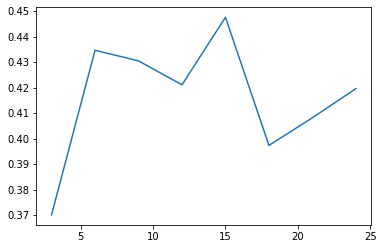

Optimal number of topics: 15






In [35]:
optimal_scores = get_optimal_alpha_and_treshold(data_bigrams_trigrams,
                                                [0.3],
                                                ['auto'],
                                                '../pipeline/04_lda/optimal_n_topics.json',
                                                start=3,
                                                end=24,
                                                step=3)

In [13]:
with open('../pipeline/04_lda/optimal_topics_280521.txt', 'w', encoding='utf8') as f:
    for entry in results_by_treshold_and_alpha:
        f.write(str(entry))
    f.close()

In [30]:
a = [1,2,3,4,5]
b = ['a','b','c','d','e']

[(i, j) for i,j in zip(a,b)]

[(1, 'a'), (2, 'b'), (3, 'c'), (4, 'd'), (5, 'e')]

In [14]:
results_by_treshold_and_alpha

[([3, 6, 9, 12, 15, 18, 21, 24, 27, 30],
  [0.348250310785881,
   0.42819645415429325,
   0.4169832605104241,
   0.4350032441718774,
   0.4344408563858347,
   0.3954674863707316,
   0.39069030956925604,
   0.41472382600954133,
   0.3976967215285569,
   0.39969787116394717]),
 ([3, 6, 9, 12, 15, 18, 21, 24, 27, 30],
  [0.35621381005046304,
   0.4305759847749229,
   0.4333194541329646,
   0.4457586481082192,
   0.4231826499720969,
   0.4284418938887937,
   0.38696342011715534,
   0.4251986433759183,
   0.39866131076421846,
   0.40343812728110734]),
 ([3, 6, 9, 12, 15, 18, 21, 24, 27, 30],
  [0.36875852050667235,
   0.4716874520904943,
   0.44929058669324573,
   0.45845897030660104,
   0.43220750984134404,
   0.4223970522366082,
   0.3821596693674087,
   0.39629200024174355,
   0.3915848830430762,
   0.4173935379022679]),
 ([3, 6, 9, 12, 15, 18, 21, 24, 27, 30],
  [0.37013745470487774,
   0.43465698737854286,
   0.4305172222345211,
   0.42111368310795694,
   0.44760612296798524,
   0.3973

In [27]:
def find_best_coherence_score(results):
    
    best_results = []

    for entry in results:
        best = max(entry[1])
        ix = entry[0][entry[1].index(best)]

0.4350032441718774 	 12
0.4457586481082192 	 12
0.4716874520904943 	 6
0.44760612296798524 	 15
0.518992433854395 	 6
0.518685444282219 	 6
0.5211091693857398 	 6
0.5075221962251065 	 6
0.4316870541796661 	 6
0.43852753764895663 	 6
0.4395176964356619 	 6
0.4576790895805432 	 6
0.4316870541796661 	 6
0.43852753764895663 	 6
0.4395176964356619 	 6
0.4576790895805432 	 6
0.4316870541796661 	 6
0.43852753764895663 	 6
0.4395176964356619 	 6
0.4576790895805432 	 6
0.4263181539710141 	 6
0.44292836340574376 	 6
0.4327206068969833 	 6
0.42609127738243907 	 6
0.4263181539710141 	 6
0.44292836340574376 	 6
0.4327206068969833 	 6
0.42609127738243907 	 6


In [20]:
results_to_df = [result[1] for result in results_by_treshold_and_alpha]

In [23]:
n_topics_and_coherence_scores = pd.DataFrame(data=results_to_df)

Computing model with 3 topics
Coherence Score:  0.3160675884818799
Computing model with 6 topics
Coherence Score:  0.2922419645183412
Computing model with 9 topics
Coherence Score:  0.30744675465938376
Computing model with 12 topics
Coherence Score:  0.3012181300886993
Computing model with 15 topics
Coherence Score:  0.3610852112316965
Computing model with 18 topics
Coherence Score:  0.36748109982516874
Computing model with 21 topics
Coherence Score:  0.3648931433130742
Computing model with 24 topics
Coherence Score:  0.36427865726735154
Computing model with 27 topics
Coherence Score:  0.3471697238274256
Computing model with 30 topics
Coherence Score:  0.3583104430923924


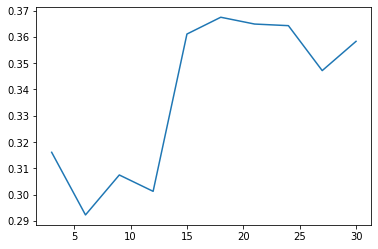

Optimal number of topics: 18
Computing model with 3 topics
Coherence Score:  0.38974961939902464
Computing model with 6 topics
Coherence Score:  0.33739297724061523
Computing model with 9 topics
Coherence Score:  0.37181289803917034
Computing model with 12 topics
Coherence Score:  0.38870056456289054
Computing model with 15 topics
Coherence Score:  0.3615807154301055
Computing model with 18 topics
Coherence Score:  0.3640528331559575
Computing model with 21 topics
Coherence Score:  0.3750427622468263
Computing model with 24 topics
Coherence Score:  0.3652506374567129
Computing model with 27 topics
Coherence Score:  0.34829459239762633
Computing model with 30 topics
Coherence Score:  0.3742848345436409


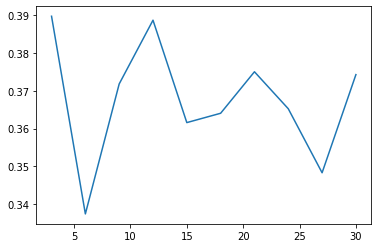

Optimal number of topics: 3
Computing model with 3 topics
Coherence Score:  0.3772659864961658
Computing model with 6 topics
Coherence Score:  0.38976705142710627
Computing model with 9 topics
Coherence Score:  0.3770694493026039
Computing model with 12 topics
Coherence Score:  0.36476843554129573
Computing model with 15 topics
Coherence Score:  0.401933050760827
Computing model with 18 topics
Coherence Score:  0.3865295717581099
Computing model with 21 topics
Coherence Score:  0.3712952361787951
Computing model with 24 topics
Coherence Score:  0.38608904805499944
Computing model with 27 topics
Coherence Score:  0.37304030255491943
Computing model with 30 topics
Coherence Score:  0.35580369648149207


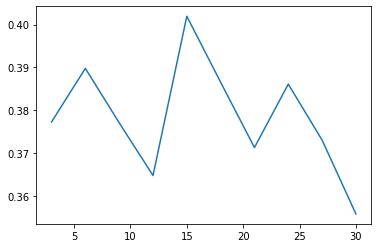

Optimal number of topics: 15
Computing model with 3 topics
Coherence Score:  0.38293335157487923
Computing model with 6 topics
Coherence Score:  0.3683256672749609
Computing model with 9 topics
Coherence Score:  0.3597716242820596
Computing model with 12 topics
Coherence Score:  0.3976055801222566
Computing model with 15 topics
Coherence Score:  0.39893020050304584
Computing model with 18 topics
Coherence Score:  0.43052574331651927
Computing model with 21 topics
Coherence Score:  0.37366590445948183
Computing model with 24 topics
Coherence Score:  0.3670005891965788
Computing model with 27 topics
Coherence Score:  0.3857890159423707
Computing model with 30 topics
Coherence Score:  0.3835629222440241


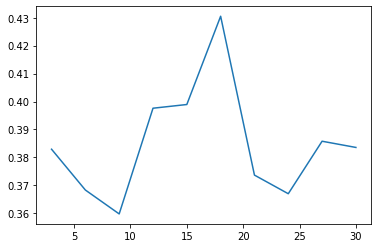

Optimal number of topics: 18
Computing model with 3 topics
Coherence Score:  0.38293335157487923
Computing model with 6 topics
Coherence Score:  0.3683256672749609
Computing model with 9 topics
Coherence Score:  0.3597716242820596
Computing model with 12 topics
Coherence Score:  0.3976055801222566
Computing model with 15 topics
Coherence Score:  0.39893020050304584
Computing model with 18 topics
Coherence Score:  0.43052574331651927
Computing model with 21 topics
Coherence Score:  0.37366590445948183
Computing model with 24 topics
Coherence Score:  0.3670005891965788
Computing model with 27 topics
Coherence Score:  0.3857890159423707
Computing model with 30 topics
Coherence Score:  0.3835629222440241


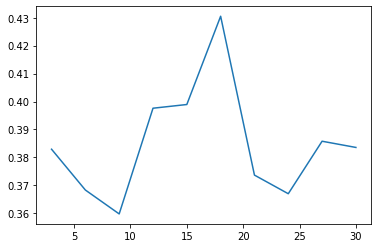

Optimal number of topics: 18
Computing model with 3 topics
Coherence Score:  0.38293335157487923
Computing model with 6 topics
Coherence Score:  0.3683256672749609
Computing model with 9 topics
Coherence Score:  0.3597716242820596
Computing model with 12 topics
Coherence Score:  0.3976055801222566
Computing model with 15 topics
Coherence Score:  0.39893020050304584
Computing model with 18 topics
Coherence Score:  0.43052574331651927
Computing model with 21 topics
Coherence Score:  0.37366590445948183
Computing model with 24 topics
Coherence Score:  0.3670005891965788
Computing model with 27 topics
Coherence Score:  0.3857890159423707
Computing model with 30 topics
Coherence Score:  0.3835629222440241


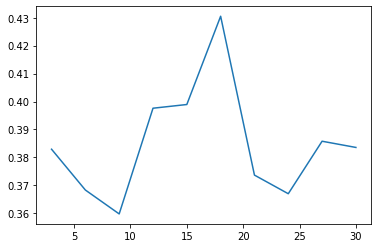

Optimal number of topics: 18
Computing model with 3 topics
Coherence Score:  0.3718644115715968
Computing model with 6 topics
Coherence Score:  0.4389279723379811
Computing model with 9 topics
Coherence Score:  0.38779155249176855
Computing model with 12 topics
Coherence Score:  0.38073109811584005
Computing model with 15 topics
Coherence Score:  0.40300935591672254
Computing model with 18 topics
Coherence Score:  0.3746034276198379
Computing model with 21 topics
Coherence Score:  0.3820201189691844
Computing model with 24 topics
Coherence Score:  0.35644115682670935
Computing model with 27 topics
Coherence Score:  0.36592082926612607
Computing model with 30 topics
Coherence Score:  0.3689575007110781


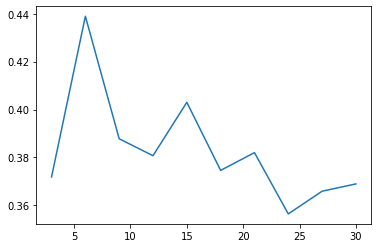

Optimal number of topics: 6
Computing model with 3 topics
Coherence Score:  0.3718644115715968
Computing model with 6 topics
Coherence Score:  0.4389279723379811
Computing model with 9 topics
Coherence Score:  0.38779155249176855
Computing model with 12 topics
Coherence Score:  0.38073109811584005
Computing model with 15 topics
Coherence Score:  0.40300935591672254
Computing model with 18 topics
Coherence Score:  0.3746034276198379
Computing model with 21 topics
Coherence Score:  0.3820201189691844
Computing model with 24 topics
Coherence Score:  0.35644115682670935
Computing model with 27 topics
Coherence Score:  0.36592082926612607
Computing model with 30 topics
Coherence Score:  0.3689575007110781


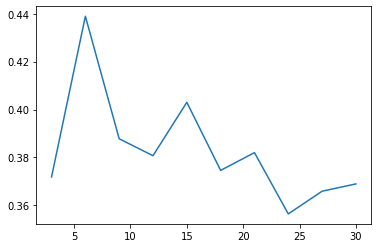

Optimal number of topics: 6
Computing model with 3 topics
Coherence Score:  0.3718644115715968
Computing model with 6 topics
Coherence Score:  0.4389279723379811
Computing model with 9 topics
Coherence Score:  0.38779155249176855
Computing model with 12 topics
Coherence Score:  0.38073109811584005
Computing model with 15 topics
Coherence Score:  0.40300935591672254
Computing model with 18 topics
Coherence Score:  0.3746034276198379
Computing model with 21 topics
Coherence Score:  0.3820201189691844
Computing model with 24 topics
Coherence Score:  0.35644115682670935
Computing model with 27 topics
Coherence Score:  0.36592082926612607
Computing model with 30 topics
Coherence Score:  0.3689575007110781


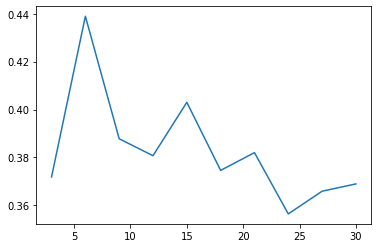

Optimal number of topics: 6


In [15]:
treshold_range = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
results_by_treshold = []

for treshold in treshold_range:
    results_by_treshold.append(get_optimal_n_topics(data_bigrams_trigrams, no_above=treshold, start=3, end=30, step=3))

In [29]:
from gensim.models import TfidfModel

id2word = corpora.Dictionary(data_bigrams_trigrams)
id2word.filter_extremes(no_above=0.4)
corpus = [id2word.doc2bow(text) for text in data_bigrams_trigrams]
tfidf = TfidfModel(corpus, id2word=id2word)

lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                            id2word=id2word,
                                            num_topics=6,
                                            random_state=100,
                                            update_every=1,
                                            chunksize=100,
                                            passes=10,
                                            alpha=0.3)

pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(lda_model, corpus, id2word, mds='mmds', R=30)

vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1      0.065389  0.218259       1        1  26.331351
2     -0.094581 -0.274974       2        1  18.985274
4     -0.307847 -0.067369       3        1  14.505599
3     -0.193515  0.285665       4        1  14.355144
5      0.191073 -0.245336       5        1  13.551223
0      0.339481  0.083754       6        1  12.271409, topic_info=             Term        Freq       Total Category  logprob  loglift
372        schiff  343.000000  343.000000  Default  30.0000  30.0000
136          herr  523.000000  523.000000  Default  29.0000  29.0000
94          stadt  616.000000  616.000000  Default  28.0000  28.0000
138         herrn  295.000000  295.000000  Default  27.0000  27.0000
14        general  229.000000  229.000000  Default  26.0000  26.0000
..            ...         ...         ...      ...      ...      ...
94          stadt   90.967065  616.443192   Topic6  -4.6185   0.1844
41            uhr   72.078986  331.207933   Topic6  -4.8512   0.5729
637  gouvernement   38.685745   56.983853   Topic6  -5.4735   1.7106
161      publikum   38.592012   63.820107   Topic6  -5.4759   1.5949
199         sache   37.519769  141.758514   Topic6  -5.5041   0.7686

[381 rows x 6 columns], token_table=      Topic      Freq         Term
term                              
975       1  0.990463  abgeordnete
667       1  0.030347       actien
667       5  0.940750       actien
1652      3  0.042570      admiral
1652      4  0.950738      admiral
...     ...       ...          ...
665       6  0.975671       zimmer
209       2  0.647420          zug
209       5  0.284865          zug
209       6  0.069058          zug
1235      6  0.981903    zuschauer

[610 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 3, 5, 4, 6, 1])

### Notes from first bigrams_trigrams LDA vis:

1. add common OCR errors to stopwords: nnd, fich, find, nnr
2. add "noisewords" ubiquitous in newspapers, like 'tag', 'uhr'

In [267]:
#readable_corpus = [[(id2word[id], freq) for id, freq in cp] for cp in corpus]

In [ ]:
# alpha and eta are hyperparameters that affect sparsity of the topics. According to the Gensim docs, both defaults to 1.0/num_topics prior.

In [158]:
def remove_hi_tf_words(corpus, treshold):
    
    corpus_wordcount = 0
    for text in corpus:
        corpus_wordcount += len(text)
    print(corpus_wordcount)
    
    frequencies = {}
    for text in corpus:
        for token in text:
            if token in frequencies.keys():
                frequencies[token] += 1
            else:
                frequencies[token] = 1
            
    print(len(frequencies))
    print(max(frequencies.values()))
            
    new_corpus = []
    
    for text in corpus:
        new_text = []
        for token in text:
            if frequencies[token]/corpus_wordcount > treshold:
                print(frequencies[token])
                new_text.append(token)
        new_corpus.append(new_text)
                
    return new_corpus